In [1]:
from qiskit import *
from numpy import *
import matplotlib.pyplot as plt
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import (
ElectronicStructureMoleculeDriver, ElectronicStructureDriverType)
from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import ParityMapper, JordanWignerMapper, BravyiKitaevMapper
from scipy.optimize import minimize
import numpy as np
from qiskit.algorithms.optimizers import COBYLA, SPSA, SLSQP, GradientDescent
from qiskit.opflow import TwoQubitReduction, Z2Symmetries
from qiskit import BasicAer, Aer
from qiskit.utils import QuantumInstance
from qiskit.quantum_info import Pauli
import time

In [2]:
def get_qubit_op(dist):
    
    molecule = Molecule(
        # Coordinates in Angstrom
        geometry=[
        ["H", [0.0, 0.0, 0.0] ],
        ["H", [dist, 0.0, 0.0] ] # One atom is placed in (0,0,0) and the other in (dist,0,0), being dist the distance between both atoms
        ],
        multiplicity=1, # = 2*spin + 1
        charge=0,
    )
    
    # The driver takes the geometry of the molecule defined above and gives us the intermediate data
    driver = ElectronicStructureMoleculeDriver(
        molecule=molecule,
        basis="sto3g",
        driver_type=ElectronicStructureDriverType.PYSCF)
    
    # The next line is needed in order to get the driver executed
    properties = driver.run()
    
    # Some properties of the molecule that are going to be needed are extracted from the data
    num_particles = (properties
        .get_property("ParticleNumber")
        .num_particles)
    num_spin_orbitals = int(properties
        .get_property("ParticleNumber")
        .num_spin_orbitals)
    nuclear_repulsion_energy = properties.get_property("ElectronicEnergy").nuclear_repulsion_energy
    
    # The problem is defined, the frozen core approximation is applied.
    problem = ElectronicStructureProblem(
        driver,
        [FreezeCoreTransformer(freeze_core=True)])
    
    # The Hamiltonian is quantized, in this case he second quantization is applied
    second_q_ops = problem.second_q_ops()
    
    # Fermion to qubit mapping, the desired mapping has to be defined. Qubit reduction is also applied.
    mapper = ParityMapper()
    hamiltonian = second_q_ops[0]
    converter = QubitConverter(mapper,two_qubit_reduction=True,z2symmetry_reduction= "auto") #the two_qubit_reduction is just applied when possible
    reducer = TwoQubitReduction(num_particles)
    qubit_op = converter.convert(hamiltonian)
    qubit_op = reducer.convert(qubit_op)
    return qubit_op, nuclear_repulsion_energy, num_particles, num_spin_orbitals, problem, converter

In [3]:
def define_ansatz(theta):
    q = QuantumRegister(2)
    c=ClassicalRegister(2)
    ansatz = QuantumCircuit(q,c)
    ansatz.rx(pi,q[1])
    ansatz.rx(-pi/2,q[1])
    ansatz.ry(pi/2,q[0])
    ansatz.cx(q[0],q[1])
    ansatz.rz(theta[0],q[1])
    ansatz.cx(q[0],q[1])
    ansatz.ry(-pi/2,q[0])
    ansatz.rx(pi/2,q[1])
    return (ansatz)

In [4]:
def Energy_general(theta, R, num_qubits, gates_list_hamiltonian, num_elements_hamiltonian):
    shots = 2**14 # Number of samples used for statistics
    sim = Aer.get_backend('aer_simulator') # The simmulator is chosen, it mimics the execution of an actual device
    # Let's define some variables
    E_sim = []
    Energy_meas = []
    index_param = 0
    
    # This first loop goes through each term in the Hamiltonian
    for measurement in gates_list_hamiltonian:
        index_param += 1 # This parameter helps us to multiply each term by the correct coefficient
        n=num_qubits # This parameter is the one in charge to put each gate in the correct qubit
        q = QuantumRegister(num_qubits)
        c = ClassicalRegister(num_qubits)
        hamiltonian_circuit = QuantumCircuit(q,c)
        
        # This loop goes through each element of a specific term of the Hamiltonian and creates the
        # circuit needed to measure its expectation value
        for sing_gate in measurement:
            n -= 1
            if sing_gate == Pauli('Z'):
                hamiltonian_circuit.measure(n,n)
            if sing_gate == Pauli('X'):
                hamiltonian_circuit.h(q[n])
                hamiltonian_circuit.measure(n,n)
            if sing_gate == Pauli('Y'):
                hamiltonian_circuit.sdg(q[n])
                hamiltonian_circuit.h(q[n])
                hamiltonian_circuit.measure(n,n)

        # Once the measurement circuit is built, it is merged with the ansatz
        qc = define_ansatz(theta).compose(hamiltonian_circuit)

        # Let´s run the simulation
        qc_trans = transpile(qc, sim)
        counts = sim.run(qc_trans, shots=shots).result().get_counts() # The results of the simulation are stored in the variable 'counts'

        # This calculates the probabilities for each term in the computational basis
        probs = {}
        for output in ['00','01', '10', '11']:
            if output in counts:
                probs[output] = counts[output]/shots
            else:
                probs[output] = 0

        # This conditionals are the ones that calculate the mean value of each term and that multiply
        # each of them by the correct coefficient of the Hamiltonian
        if measurement == Pauli('ZZ'):
            Energy_meas.append(float(R[index_param].real) *(probs['00'] - probs['01'] - probs['10'] + probs['11']) )
        if measurement == Pauli('IZ'):
            Energy_meas.append(float(R[index_param].real) *(probs['00'] + probs['01'] - probs['10'] - probs['11']) )
        if measurement == Pauli('ZI'):
            Energy_meas.append(float(R[index_param].real) *(probs['00'] - probs['01'] + probs['10'] - probs['11']) )
        if measurement == Pauli('XX'):
            Energy_meas.append(float(R[index_param].real) *(probs['00'] - probs['01'] - probs['10'] + probs['11']) )
    E_sim.append(np.sum(np.array(Energy_meas)))
    # The value that returns this function is the sum of the coefficients multiplied by the expectation value
    # of each term, added to the coefficient that goes with the term II and to the repulsion term.
    return E_sim[0] + float(R[0].real) + float(R[num_elements_hamiltonian].real)

In [5]:
start_time = time.time()

distances = np.arange(0.2, 3.0, 0.05) # Array that defines the distances that are going to be evaluated
theta = np.random.rand(1) # Initial value of the parameter of the ansatz

# Some variables are defined
R = []
bond_length = []
energies = []
angles = []
gates_list_hamiltonian = []
gates_list_hamiltonian2 = []

# This loop determines the distances that are going to be evaluated
for dist in distances:
    (qubit_op, nuclear_repulsion_energy, num_particles, num_spin_orbitals, problem, converter) = get_qubit_op(dist)
   
    # This lines define some variables that are going to be needed
    hamiltonian_matrix = qubit_op # Hamiltonian with its gates and coefficients
    nuclear_repulsion_term = nuclear_repulsion_energy
    coefficients_array = hamiltonian_matrix.coeffs 
    # The next two lines extract the coefficients from the Hamiltonian and store them in an array
    coefficients_array = np.array(coefficients_array)
    R = np.append(coefficients_array, nuclear_repulsion_term) # This is an array consisting of the previous coefficients array and the repulsion term
    gates_list_hamiltonian = qubit_op.settings['primitive'].paulis # This extracts the Pauli strings that form the mapped Hamiltonian and stores them into a list
    num_elements_hamiltonian = len(gates_list_hamiltonian)
    gates_list_hamiltonian2 = gates_list_hamiltonian[1:num_elements_hamiltonian] # The Pauli string consisting of II is removed from the previous list
    num_qubits = qubit_op.num_qubits
    
    # The optimization is performed, the function that calculates the mean value of the Hamiltonian is called
    # and the desired optimizer is selected
    ret = minimize(Energy_general, theta, args = (R, num_qubits, gates_list_hamiltonian2, num_elements_hamiltonian),method= 'COBYLA')
    
    # This stores the results of the optimization in the following variables
    val = ret.fun
    ang = ret.x[0]
    
    # The results are stored in arrays in order to graphically represent them later
    bond_length.append(dist)
    energies.append(val)
    angles.append(ang)
   
    # Let's print the results
    print('For the bond length ', dist, 'the ground state energy is',val)
    print('The minimum of the energy is reached when the ansatz takes the parameter', ang)
print("--- %s seconds ---" % (time.time() - start_time))

For the bond length  0.2 the ground state energy is 0.15917564301412046
The minimum of the energy is reached when the ansatz takes the parameter 0.12759556720687226
For the bond length  0.25 the ground state energy is -0.3117993647955708
The minimum of the energy is reached when the ansatz takes the parameter 0.06460728595687225
For the bond length  0.3 the ground state energy is -0.6024979973060893
The minimum of the energy is reached when the ansatz takes the parameter 0.12789556720687223
For the bond length  0.35 the ground state energy is -0.785479107983736
The minimum of the energy is reached when the ansatz takes the parameter 0.12588658283187226
For the bond length  0.39999999999999997 the ground state energy is -0.9153610711410758
The minimum of the energy is reached when the ansatz takes the parameter 0.10435806720687237
For the bond length  0.44999999999999996 the ground state energy is -0.9993798611757072
The minimum of the energy is reached when the ansatz takes the paramet

For the bond length  2.55 the ground state energy is -0.9355627542975711
The minimum of the energy is reached when the ansatz takes the parameter 1.4407838484568722
For the bond length  2.5999999999999996 the ground state energy is -0.9350539403610775
The minimum of the energy is reached when the ansatz takes the parameter 1.3696830672068723
For the bond length  2.6499999999999995 the ground state energy is -0.934366579786766
The minimum of the energy is reached when the ansatz takes the parameter 1.3777955672068722
For the bond length  2.6999999999999997 the ground state energy is -0.9345659137717078
The minimum of the energy is reached when the ansatz takes the parameter 1.4246705672068722
For the bond length  2.7499999999999996 the ground state energy is -0.9339510647856806
The minimum of the energy is reached when the ansatz takes the parameter 1.4679834578318722
For the bond length  2.8 the ground state energy is -0.9339964330946089
The minimum of the energy is reached when the an

In [6]:
t = 297.6309299468994 / 60.
print('mins = ', t)

mins =  4.96051549911499


In [31]:
import plotly.express as px
fig = px.scatter(x=bond_length, y=energies)
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

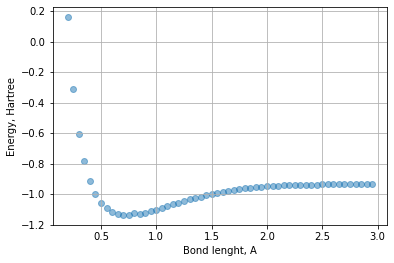

In [28]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
plt.scatter(bond_length, energies, alpha=0.5)
ax.grid(True)
plt.xlabel("Bond lenght, A")
plt.ylabel("Energy, Hartree")
plt.show()

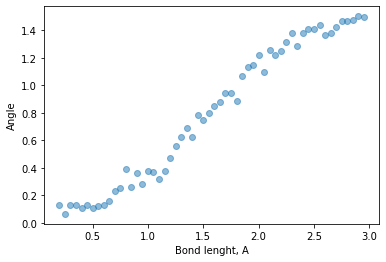

In [30]:
plt.scatter(bond_length,angles, alpha=0.5)
ax.grid(True)
plt.xlabel("Bond lenght, A")
plt.ylabel("Angle")
plt.show()